<a href="https://colab.research.google.com/github/jillnoorily/iphs290_cultural_analytics_lda_topic_modeling/blob/main/LDA_topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Jon Chun
24 Oct 2021

# **Requirements**

* Must use **Chrome** browser (esp not Safari)
* Use only **plain text** files (no *.rtf, *.doc, etc)

# **Setup and Configuration**

In [ ]:
!pip install clean-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 14.2 MB/s 
     |████████████████████████████████| 53 kB 764 kB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=3a2c1914bb721eda7497beaf102eacb581c57c941026316ae8ea17f85d1a3c65
  Stored in directory: /root/.cache/pip/wheels/5e/8c/80/c3646df8201ba6f5070297fe3779a4b70265d0bfd961c15302
Successfully built emoji


In [ ]:
!pip install unidecode  # clean-text dependency

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 10.5 MB/s 


In [ ]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110 kB 14.4 MB/s 
     |████████████████████████████████| 287 kB 87.2 MB/s 


In [ ]:
!pip install python-slugify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Python Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re

from cleantext import clean
import contractions
from slugify import slugify

from scipy.signal import find_peaks

from google.colab import files



In [ ]:
# Setup matplotlib

# %matplotlib inline

plt.rcParams["figure.figsize"] = (20,10)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Globals

In [ ]:
# Global Vars

novel_filename_str = ''
novel_title_str = ''
novel_raw_str = ''
novel_clean_str = ''

novel_lines_ls = []
novel_sentences_ls = []
novel_paragraphs_ls = []

# Main (Modin) DataFrame for Novel Sentiments
sentiment_df = pd.DataFrame

TEXT_ENCODING = 'utf-8'

In [ ]:
def verify_novel(anovel_raw_str, anovel_title_str, index_ends=500):
  '''
  INPUT: string in some stage of processing
  OUTPUT: display summary index_ends chars of header/footer for verification
  '''

  print(f'Novel Title: {anovel_title_str}')
  print(f'  Char Len: {len(anovel_raw_str)}')
  print('====================================\n')
  print(f'Beginning:\n\n {anovel_raw_str[:index_ends]}\n\n')
  print('\n------------------------------------')
  print(f'Ending:\n\n {anovel_raw_str[-index_ends:]}\n\n')

In [ ]:
def save_text2txt_and_download(text_obj, file_suffix='_save.txt'):
  '''
  INPUT: text object and suffix to add to output text filename
  OUTPUT: Write text object to text file (both temp VM and download)
  '''

  if type(text_obj) == str:
    print('STEP 1. Processing String Object\n')
    str_obj = text_obj
  elif type(text_obj) == list:
    if (len(text_obj) > 0):
      if type(text_obj[0]) == str:
        print('STEP 1. Processing List of Strings Object\n')
        str_obj = "\n".join(text_obj)
      else:
        print('ERROR: Object is not an List of Strings [save_text2txt_and_download()]')
        return -1
    else:
      print('ERROR: Object is an empty List [save_text2txt_and_download()]')
      return -1
  else:
    print('ERROR: Object Type is neither String nor List [save_text2txt_and_download()]')
    return -1

  datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  # out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix
  out_filename = novel_name_str.split('.')[0] + file_suffix

  # Write file to temporary VM filesystem
  print(f'STEP 2. Saving textfile to temporary VM file: {out_filename}\n')
  with open(out_filename, "w") as fp:
    fp.write(str_obj)

  # Download permanent copy of file
  print(f'STEP 3. Downloading permanent copy of textfile: {out_filename}\n')
  files.download(out_filename)

In [ ]:
def save_df2csv_and_download(df_obj, file_suffix='_save.csv', nodate=True):
  '''
  INPUT: DataFrame object and suffix to add to output csv filename
  OUTPUT: Write DataFrame object to csv file (both temp VM and download)
  '''

  if isinstance(df_obj, pd.DataFrame):
    datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    if nodate:
      out_filename = novel_name_str.split('.')[0] + file_suffix
    else:
      out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix
    # print(f'STEP 1. Saving DataFrame: {df_obj.__name__} to temporary VM file: {out_filename}\n') # Also, isinstance(obj, pd.DataFrame)
    print(f'STEP 1. Saving DataFrame to temporary VM file: {out_filename}\n')
    df_obj.to_csv(out_filename, index=False) 
  else:
    print(f'ERROR: Object is not a DataFrame [save_df2csv_and_download()]')
    return -1

  # Download permanent copy of file
  print(f'STEP 2. Downloading permanent copy of csvfile: {out_filename}\n')
  files.download(out_filename)


# Test

# save_df2csv_and_download(temp_df, '_bert-nlptown.txt')

In [ ]:
def expand_contractions(input_str):
  '''
  INPUT: long string
  OUTPUT: long string with expanded contractions
  '''

  output_str = contractions.fix(input_str)

  return output_str

"""
# novel_clean_ls = [re.sub(r'[\n]+', ' ', x).strip() for x in novel_ls]
novel_clean_ls = [contractions.fix(x) for x in novel_ls]
novel_clean_ls = [re.sub(r'[\n]+', ' ', x).strip() for x in novel_clean_ls]
novel_clean_ls = [x.strip() for x in novel_clean_ls if len(x.strip()) > 1]
# novel_clean_ls = [re.sub(r"^[\"\']", "", x) for x in novel_clean_ls]  # re.sub("[\"\']", "", s)
# novel_clean_ls = [re.sub(r"[\"\']$", "", x) for x in novel_clean_ls]
novel_clean_ls = [x.encode('ascii',errors='ignore').decode() for x in novel_clean_ls]
# novel_bin = novel_clean_str.encode('ascii',errors='ignore')
# novel_clean_str = novel_bin.decode()

[f'[{x}]' for x in novel_clean_ls]
"""

'\n# novel_clean_ls = [re.sub(r\'[\n]+\', \' \', x).strip() for x in novel_ls]\nnovel_clean_ls = [contractions.fix(x) for x in novel_ls]\nnovel_clean_ls = [re.sub(r\'[\n]+\', \' \', x).strip() for x in novel_clean_ls]\nnovel_clean_ls = [x.strip() for x in novel_clean_ls if len(x.strip()) > 1]\n# novel_clean_ls = [re.sub(r"^["\']", "", x) for x in novel_clean_ls]  # re.sub("["\']", "", s)\n# novel_clean_ls = [re.sub(r"["\']$", "", x) for x in novel_clean_ls]\nnovel_clean_ls = [x.encode(\'ascii\',errors=\'ignore\').decode() for x in novel_clean_ls]\n# novel_bin = novel_clean_str.encode(\'ascii\',errors=\'ignore\')\n# novel_clean_str = novel_bin.decode()\n\n[f\'[{x}]\' for x in novel_clean_ls]\n'

# **Get the Novel Text**

## OPTION (a): Upload Raw Textfile

In [ ]:
%%time

# NOTE: 1m07s

# Upload Plain Text File
uploaded = files.upload()

# NOTE: Allows for multiple file uploads, will only process the last
#       Left in for future feature addition (processing multiple files at once)
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  novel_filename_str = fn

# Extract from Dict and decode binary into char string
novel_raw_str = uploaded[novel_filename_str].decode(TEXT_ENCODING)

Saving Their Eyes Were Watching God.txt to Their Eyes Were Watching God (1).txt
User uploaded file "Their Eyes Were Watching God.txt" with length 330798 bytes
CPU times: user 117 ms, sys: 21.7 ms, total: 139 ms
Wall time: 10.3 s


In [ ]:
#@title Enter Novel_Title in the form [Title] by [Author]

Novel_Title = "Their Eyes Were Watching God" #@param {type:"string"}

# Remove illegal filename punctuation
Novel_Title = Novel_Title.replace("'","")
Novel_Title = Novel_Title.replace('"','')
Novel_Title = Novel_Title.replace('.',' ')

novel_title_str = ' '.join([x.capitalize() for x in slugify(Novel_Title).replace('-',' ').split()])
novel_title_str

'Their Eyes Were Watching God'

In [ ]:
# CHECK: That you've trimmed the header/footer before uploading

print(f'Novel Filename:\n\n  {novel_filename_str}\n\n')

verify_novel(novel_raw_str, novel_title_str)

Novel Filename:

  Their Eyes Were Watching God.txt


Novel Title: Their Eyes Were Watching God
  Char Len: 318259

Beginning:

 ﻿Their Eyes Were Watching God
1


Ships at a distance have every man’s wish on board. For some they come in with the tide. For others they sail forever on the horizon, never out of sight, never
landing until the Watcher turns his eyes away in resignation, his dreams mocked to death by Time. That is the life of men.
Now, women forget all those things they don’t want to remember, and remember everything they don’t want to forget. The dream is the truth. Then they act and do
things according



------------------------------------
Ending:

 e sigh flew
out of the window and lit in the top of the pine trees. Tea Cake, with the sun for a shawl. Of course he wasn’t dead. He could never be dead until she herself had


finished feeling and thinking. The kiss of his memory made pictures of love and light against the wall. Here was peace. She pulled in her horizon like

## OPTION (b): Read from gDrive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive

MessageError: ignored

In [ ]:
# drive.mount("/gdrive", force_remount=True)

In [ ]:
# CUSTOMIZE: set GDrive path below

%cd ./MyDrive/courses/2021f_iphs200_programming_humanity/code/

In [ ]:
!ls *.txt

In [ ]:
# CUSOTMIZE: set 'novel_filename' to the filename of your novel

# novel_filename = 'jkrowling_1sorcerersstone.txt'
novel_filename_str ='Percy_Jackson_The_Lightning_Thief.txt'

In [ ]:
#@title Enter Novel_Title in the form [Title] by [Author]

Novel_Title = "Their Eyes Were Watching God" #@param {type:"string"}
novel_title_str = Novel_Title

In [ ]:
# Read file into string

with open(novel_filename_str, "r") as fp:
  novel_raw_str = fp.read() #reading all the content in one step

In [ ]:
# Verify

# CHECK: That you've trimmed the header/footer before uploading

print(f'Novel Filename:\n\n  {novel_filename_str}\n\n')

verify_novel(novel_raw_str, novel_title_str)

Novel Filename:

  Their Eyes Were Watching God.txt


Novel Title: Their Eyes Were Watching God
  Char Len: 315238

Beginning:

 ﻿Their Eyes Were Watching God
1


Ships at a distance have every man’s wish on board. For some they come in with the tide. For others they sail forever on the horizon, never out of sight, never
landing until the Watcher turns his eyes away in resignation, his dreams mocked to death by Time. That is the life of men.
Now, women forget all those things they don’t want to remember, and remember everything they don’t want to forget. The dream is the truth. Then they act and do
things accordingly.
So 



------------------------------------
Ending:

 of the sigh flew
out of the window and lit in the top of the pine trees. Tea Cake, with the sun for a shawl. Of course he wasn’t dead. He could never be dead until she herself had


finished feeling and thinking. The kiss of his memory made pictures of love and light against the wall. Here was peace. She pulled in her 

In [ ]:
# END

In [ ]:
# Read novel into list of Paragraphs

delimiter = "\n\n"

with open(novel_filename, "r") as fp:
  novel_raw_str = fp.read() #reading all the content in one step
  #using the string methods we split it
  novel_parags_ls = novel_raw_str.split(delimiter)
  novel_parags_ls = [x.strip() for x in novel_parags_ls if len(x.strip()) > 2]

print(f'Paragraph Count: {len(novel_parags_ls)}')

NameError: ignored

In [ ]:
# Read novel into list of Lines

# may need delimiter

with open(novel_filename, 'r') as fp:
  novel_lines_ls = fp.readlines()

print(f'Line Count: {len(novel_lines_ls)}')

NameError: ignored

In [ ]:
novel_parags_ls[:10]

In [ ]:
novel_ls[100:110]

In [ ]:
# novel_clean_ls = [re.sub(r'[\n]+', ' ', x).strip() for x in novel_ls]
novel_clean_ls = [contractions.fix(x) for x in novel_ls]
novel_clean_ls = [re.sub(r'[\n]+', ' ', x).strip() for x in novel_clean_ls]
novel_clean_ls = [x.strip() for x in novel_clean_ls if len(x.strip()) > 1]
# novel_clean_ls = [re.sub(r"^[\"\']", "", x) for x in novel_clean_ls]  # re.sub("[\"\']", "", s)
# novel_clean_ls = [re.sub(r"[\"\']$", "", x) for x in novel_clean_ls]
novel_clean_ls = [x.encode('ascii',errors='ignore').decode() for x in novel_clean_ls]
# novel_bin = novel_clean_str.encode('ascii',errors='ignore')
# novel_clean_str = novel_bin.decode()

[f'[{x}]' for x in novel_clean_ls]

In [ ]:
novel_clean_str = '\n'.join(novel_clean_ls)
print(novel_clean_str[:5000])

In [ ]:
# novel_clean_ls[1] = "THE SILVER SPOON I was born twice: first, as a baby girl, on a remarkably smogless Detroit day in January of 1960; and then again, as a teenage boy, in an emergency room near Petoskey, Michigan, in August of 1974. Specialized readers may have come across me in Dr. Peter Luce’s study, “Gender Identity in 5-Alpha-Reductase Pseudohermaphrodites,” published in theJournal of Pediatric Endocrinology in 1975. Or maybe you’ve seen my photograph in chapter sixteen of the now sadly outdatedGenetics and Heredity."

In [ ]:
# novel_clean_ls.pop(0)

In [ ]:
novel_clean_ls[:10]

In [ ]:
novel_clean_ls[-10:]

In [ ]:
# novel_clean_str = '\n'.join(novel_clean_ls)

# novel_bin = novel_clean_str.encode('ascii',errors='ignore')
# novel_clean_str = novel_bin.decode()

# print(novel_clean_str[:5000])

## OPTION (c): Scrape Project Gutenberg

**Goto *https://gutenberg.net.au* and find the *.HTML (not *.TXT) version of your novel**

In [ ]:
from bs4 import BeautifulSoup

import requests

In [ ]:
#@title Enter the URL of your novel at ***gutenberg.net.au***
#@markdown Paste the URL to the ***HTML version*** (not plain text).

Novel_Title = 'Frankenstein by Mary Shelley'  #@param {type: "string"}

Gutenberg_URL = 'https://gutenberg.net.au/ebooks/z00006.html'  #@param {type: "string"}


In [ ]:
# Get raw HTML of novel from Gutenberg.net.au

response=requests.get(Gutenberg_URL)  # TODO: Pass the URL to the .get() method of the requests object
html = response.text

In [ ]:
# View raw HTML that we need to clean up

# TODO: What is the difference between these two outputs?

# Option A: 
html

# Option B:
# print(html)

In [ ]:
# Use HTML <p> to extract text into list of paragraphs

soup = BeautifulSoup(html, "html.parser")


paragraph=soup.find_all("p")  # TODO: get all the <P>Paragraphs</P> 
                                #       see bs4 API ref: https://beautiful-soup-4.readthedocs.io/en/latest/#kinds-of-objects
parag_ls = []
for para in paragraph:
    parag_ls.append(para.text)

print(f'There were {len(parag_ls)} Paragraphs:\n') # TODO how do you get the number of paragraphs in the list parag_ls?

print(f"First 3 Paragraphs: ==============================    \n")
print(f"    {list(print(x) for x in parag_ls[:3])}\n")  # TODO: Give index to retrieve the first 3 paragraphs

print(f"Last 3 Paragraphs: ============================== \n")
print(f"    {list(print(x) for x in parag_ls[-3:])}\n")  # TODO: Give index to retrieve the last 3 paragraphs


In [ ]:
# Concatenate all paragraphs into a single novel string

# For every paragraph, replace all hardcoded \r\n with a single space
parag_flat_ls = [re.sub(r'\r\n', ' ', aparag) for aparag in parag_ls]

# Concatenate all paragraphs into a single string, separated by two \n
novel_raw_str = '\n\n'.join(parag_flat_ls)

print('\nSTART OF NOVEL: -----')
print(novel_raw_str[:1000] + '\n')

print('\nEND OF NOVEL: -----\n')
print(novel_raw_str[-1000:])

**Enter the First and Last several words to use as RegEx for trimming header/footers**

In [ ]:
#@title Enter the first sentence in the body of your novel
sentence_first_str = 'St. Petersburgh, Dec. 11th'  #@param {type: "string"}




In [ ]:
#@title Enter the last sentence in the body of your novel
sentence_last_str = 'waves and lost in darkness and distance.'  #@param {type: "string"}

In [ ]:
# Strip off the header
# novel_clean = ' '.join(novel_str.partition(sentence_first_str)[1:])

# Strip off the footer
# ' '.join(novel_clean.partition(sentence_last_str)[:2])[-500:]

In [ ]:
# Strip off the header
novel_raw_str = ' '.join(novel_raw_str.partition(sentence_first_str)[1:])

# Strip off the footer
novel_raw_str = ' '.join(novel_raw_str.partition(sentence_last_str)[:2])

# Verify

print('\nSTART OF CLEAN NOVEL: -----')
print(novel_raw_str[:1000] + '\n')

print('\nEND OF CLEAN NOVEL: -----\n')
print(novel_raw_str[-1000:])

In [ ]:
# END

In [ ]:
# CUSTOMIZE: Set delimiter to one (\n) or two (\n\n) returns

# Read novel into list of Paragraphs

delimiter = "\n\n" # or "\n"

novel_paragraphs_ls = novel_raw_str.split(delimiter)
novel_paragraphs_ls = [x.strip() for x in novel_paragraphs_ls if len(x.strip()) > 2]
novel_paragraphs_ls = [' '.join(x.split()) for x in novel_paragraphs_ls]

print(f'Paragraph Count: {len(novel_paragraphs_ls)}')

In [ ]:
# Verify you have list of paragraphs, not sentences

novel_paragraphs_ls[:15]

In [ ]:
for i,aline in enumerate(novel_paragraphs_ls):
  if (len(aline.strip()) < 5):
    print(f'Line #{i}: {aline}')

In [ ]:
novel_clean_str = '\n'.join(novel_parags_ls)
novel_clean_str[:2000]

# **Split Novel into Sentences**

* https://github.com/zaemyung/sentsplit (CRF: mincut)

* https://github.com/adobe/NLP-Cube and Rank ~15 https://aclanthology.org/K18-2017.pdf

In [ ]:
import nltk

nltk.download('punkt')

from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
novel_sentences_ls = sent_tokenize(novel_raw_str)

sent_ct = len(novel_sentences_ls)
sent_show = 10

print('\nFirst Sentences: -----\n')
# for i, asent in enumerate(novel_sentences_ls[:sent_show]):
for i, asent in enumerate(novel_sentences_ls[:sent_show]):
  print(f'Sentences #{i}: {asent}')


print('\nLast Sentences: -----\n')
for i, asent in enumerate(novel_sentences_ls[-sent_show:]):
  print(f'Sentences #{sent_ct - (sent_show - i)}: {asent}')


print(f'\n\nThere are {sent_ct} Sentences in the novel')


First Sentences: -----

Sentences #0: ﻿The Project Gutenberg eBook of Bartleby, The Scrivener, by Herman Melville


This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever.
Sentences #1: You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this eBook or online at
www.gutenberg.org.
Sentences #2: If you are not located in the United States, you
will have to check the laws of the country where you are located before
using this eBook.
Sentences #3: Title: Bartleby, The Scrivener
       A Story of Wall-Street


Author: Herman Melville


Release Date: February 23, 2004 [eBook #11231]
[Most recently updated: January 6, 2022]


Language: English




Produced by: Steve J. Nelson and Clara T. Nelson


*** START OF THE PROJECT GUTENBERG EBOOK BARTLEBY, THE SCRIVENER ***








Bartleby, The Scrivener


A STORY OF WALL-STREET.
Sentences #4: by He

In [ ]:
# Delete the empty Sentences and those without any alphabetic characters

novel_sentences_ls = [x.strip() for x in novel_sentences_ls if len(x.strip()) > 0]
novel_sentences_ls = [x.strip() for x in novel_sentences_ls if re.search('[a-zA-Z]', x)]
len(novel_sentences_ls)

817

In [ ]:
# View the shortest Setences

sorted(novel_sentences_ls, key=len)[:100]
# type(min(novel_sentences_ls, key=len))
# novel_sentences_ls[:1000]

['Yes.',
 '“Mr.',
 'How?',
 '1.B.',
 '1.C.',
 '1.D.',
 '1.E.',
 '1.F.',
 'What!',
 'What!',
 '1.E.2.',
 '1.E.3.',
 '1.E.4.',
 '1.E.5.',
 '1.E.6.',
 '1.E.7.',
 '1.E.8.',
 '1.E.9.',
 '1.F.1.',
 '1.F.2.',
 '1.F.3.',
 '1.F.4.',
 '1.F.5.',
 '1.F.6.',
 'But no.',
 'But no.',
 'But how?',
 'No reply.',
 '“Bartleby!',
 'No answer.',
 '“Deranged?',
 'Section 1.',
 'Section 2.',
 'Not at all.',
 'Poor fellow!',
 'Think of it.',
 'Ah Bartleby!',
 'Ah humanity!',
 'I am content.',
 'No more then.',
 'Dead letters!',
 'Is it\r\nnot so?',
 '“Why, how now?',
 'I was touched.',
 'All was still.',
 'He said it was.',
 'deranged is it?',
 'It was Bartleby.',
 'He must be gone.',
 'What shall I do?',
 'What shall I do?',
 'I am getting old.',
 '“What do you mean?',
 'oh yes—queer word.',
 'I tried the\r\nknob.',
 'Will you not speak?',
 'A hot, spicy thing.',
 'Bartleby was there.',
 'what ought I to do?',
 'That is too absurd.',
 '“I am the grub-man.',
 'Are you moon-struck?',
 'It is\r\ncommon usage.',

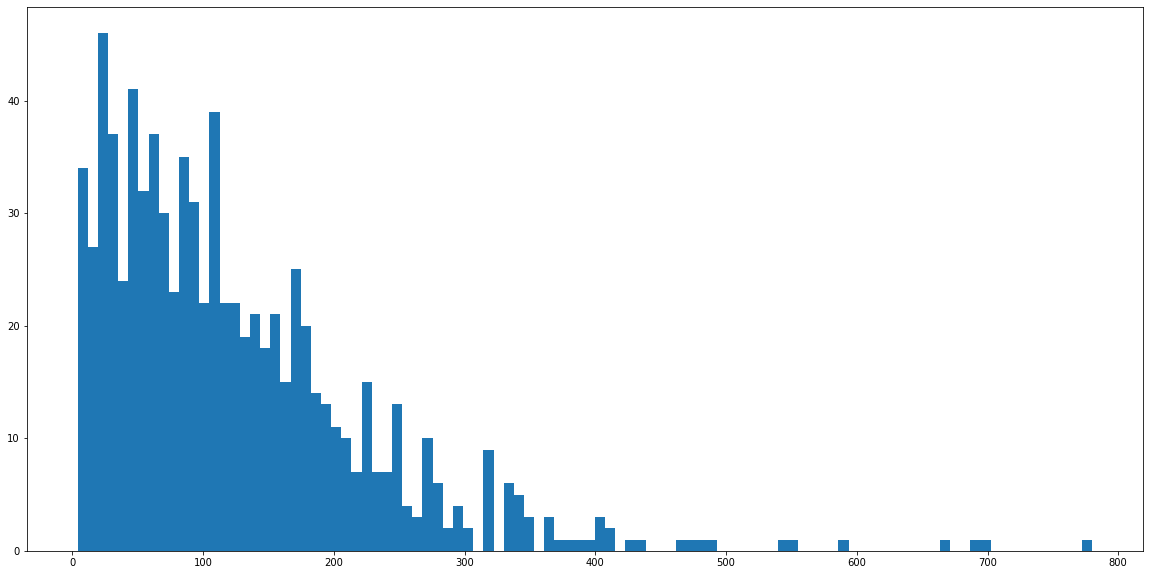

In [ ]:
# View distribution of sentence lengths

_ = plt.hist([len(x) for x in novel_sentences_ls], bins=100)

# **Clean and Slice Strings**

In [ ]:
def clean_str(dirty_str):
  '''
  INPUT: a raw string
  OUTPUT: a clean string
  '''

  contraction_expanded_str = contractions.fix(dirty_str)

  clean_str = clean(contraction_expanded_str,
      fix_unicode=True,               # fix various unicode errors
      to_ascii=True,                  # transliterate to closest ASCII representation
      lower=True,                     # lowercase text
      no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
      no_urls=False,                  # replace all URLs with a special token
      no_emails=False,                # replace all email addresses with a special token
      no_phone_numbers=False,         # replace all phone numbers with a special token
      no_numbers=False,               # replace all numbers with a special token
      no_digits=False,                # replace all digits with a special token
      no_currency_symbols=False,      # replace all currency symbols with a special token
      no_punct=False,                 # remove punctuations
      # replace_with_punct="",          # instead of removing punctuations you may replace them
      # replace_with_url="<URL>",
      # replace_with_email="<EMAIL>",
      # replace_with_phone_number="<PHONE>",
      # replace_with_number="<NUMBER>",
      # replace_with_digit="0",
      # replace_with_currency_symbol="<CUR>",
      lang="en"                       # set to 'de' for German special handling
  )

  # Replace all new lines/returns with single whitespace
  clean_str = ' '.join(clean_str.split())
  # clean_str = clean_str.replace('\n\r', ' ')
  # clean_str = clean_str.replace('\n', ' ')
  # clean_str = clean_str.replace('\r', ' ')
  # clean_str = ' '.join(clean_str.split())

  # Strip unpaired leading/trailing quotes
  if (clean_str.count('"') % 2 == 1):
    clean_str = clean_str.strip('"')
  if (clean_str.count("'") % 2 == 1):
    clean_str = clean_str.strip("'")

  return clean_str 

# Test

clean_str("This \n\n\n is a very dirty DIRTY StrInG!!")
clean_str('"up!')
clean_str('"Watch out!" he said.')

'this is a very dirty dirty string!!'

'up!'

'"watch out!" he said.'

In [ ]:
# Verify

# verify_novel(novel_clean_str, index_ends=500)

In [ ]:
# Create sentiment_df to hold text sentences and corresponding sentiment values

sentiment_df = pd.DataFrame({'text_raw': novel_sentences_ls})
sentiment_df['text_raw'] = sentiment_df['text_raw'].astype('string')
sentiment_df['text_raw'] = sentiment_df['text_raw'].str.strip()

sentiment_df.head()
sentiment_df.info()

,text_raw
0,"﻿The Project Gutenberg eBook of Bartleby, The ..."
1,"You may copy it, give it away or re-use it und..."
2,"If you are not located in the United States, y..."
3,"Title: Bartleby, The Scrivener A Story..."
4,by Herman Melville I am a rat...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817 entries, 0 to 816
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text_raw  817 non-null    string
dtypes: string(1)
memory usage: 6.5 KB


In [ ]:
# clean the 'text_raw' column and create the 'text_clean' column

# novel_df['text_clean'] = hero.clean(novel_df['text_raw'])
sentiment_df['text_clean'] = sentiment_df['text_raw'].apply(lambda x: clean_str(x))
sentiment_df['text_clean'] = sentiment_df['text_clean'].astype('string')
sentiment_df['text_raw_len'] = sentiment_df['text_raw'].apply(lambda x: len(x))

sentiment_df.head()
sentiment_df.info()

,text_raw,text_clean,text_raw_len
0,"﻿The Project Gutenberg eBook of Bartleby, The ...","the project gutenberg ebook of bartleby, the s...",237
1,"You may copy it, give it away or re-use it und...","you may copy it, give it away or re-use it und...",150
2,"If you are not located in the United States, y...","if you are not located in the united states, y...",140
3,"Title: Bartleby, The Scrivener A Story...","title: bartleby, the scrivener a story of wall...",409
4,by Herman Melville I am a rat...,by herman melville i am a rather elderly man.,62


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817 entries, 0 to 816
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text_raw      817 non-null    string
 1   text_clean    817 non-null    string
 2   text_raw_len  817 non-null    int64 
dtypes: int64(1), string(2)
memory usage: 19.3 KB


In [ ]:
# Drop Sentence if Raw length < 1 (Double check)

# sentiment_df = sentiment_df[sentiment_df['text_raw_len'] > 0]

print(f"\n\nThere are {sentiment_df['text_raw'].isna().sum()} BLANK [text_raw] lines")

print(f"There are {sentiment_df['text_clean'].isna().sum()} BLANK [text_clean] lines")

sentiment_df.shape



There are 0 BLANK [text_raw] lines
There are 0 BLANK [text_clean] lines


(817, 3)

In [ ]:
sentiment_df.sort_values(by=['text_raw_len']).head(20)

,text_raw,text_clean,text_raw_len
717,1.B.,1.b.,4
735,1.E.,1.e.,4
500,How?,how?,4
730,1.D.,1.d.,4
363,“Mr.,mr.,4
768,1.F.,1.f.,4
724,1.C.,1.c.,4
226,Yes.,yes.,4
552,What!,what!,5
555,What!,what!,5


# **Sentiment Analysis**

## **VADER**

In [ ]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 14.0 MB/s 


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

vader_sa = SentimentIntensityAnalyzer()

In [ ]:
vader_sa.polarity_scores('I love lint')['compound']

0.6369

In [ ]:
sentiment_df['vader'] = sentiment_df['text_clean'].apply(lambda x : vader_sa.polarity_scores(x)['compound'])
sentiment_df.head(10)

,text_raw,text_clean,text_raw_len,vader
0,"﻿The Project Gutenberg eBook of Bartleby, The ...","the project gutenberg ebook of bartleby, the s...",237,-0.0790
1,"You may copy it, give it away or re-use it und...","you may copy it, give it away or re-use it und...",150,0.0000
2,"If you are not located in the United States, y...","if you are not located in the united states, y...",140,0.4215
3,"Title: Bartleby, The Scrivener A Story...","title: bartleby, the scrivener a story of wall...",409,0.0000
4,by Herman Melville I am a rat...,by herman melville i am a rather elderly man.,62,0.0000
5,The nature of my avocations for the last thir...,the nature of my avocations for the last thirt...,274,0.4019
6,"I have known very many of them, professionall...","i have known very many of them, professionally...",192,0.4588
7,But I waive the biographies of all other scriv...,but i waive the biographies of all other scriv...,158,0.0000
8,While of other law-copyists I might write the...,while of other law-copyists i might write the ...,107,0.0000
9,I believe that no materials exist for a full a...,i believe that no materials exist for a full a...,85,0.0772


## **TextBlob**

In [ ]:
from textblob import TextBlob

In [ ]:
testimonial = TextBlob("Textblob is amazingly simple to use. What great fun!")
print(testimonial.sentiment.polarity)

0.39166666666666666


In [ ]:
sentiment_df['textblob'] = sentiment_df['text_clean'].apply(lambda x : TextBlob(x).sentiment.polarity)
sentiment_df.head(10)

,text_raw,text_clean,text_raw_len,vader,textblob
0,"﻿The Project Gutenberg eBook of Bartleby, The ...","the project gutenberg ebook of bartleby, the s...",237,-0.0790,0.187500
1,"You may copy it, give it away or re-use it und...","you may copy it, give it away or re-use it und...",150,0.0000,0.000000
2,"If you are not located in the United States, y...","if you are not located in the united states, y...",140,0.4215,0.000000
3,"Title: Bartleby, The Scrivener A Story...","title: bartleby, the scrivener a story of wall...",409,0.0000,0.166667
4,by Herman Melville I am a rat...,by herman melville i am a rather elderly man.,62,0.0000,0.000000
5,The nature of my avocations for the last thir...,the nature of my avocations for the last thirt...,274,0.4019,0.087500
6,"I have known very many of them, professionall...","i have known very many of them, professionally...",192,0.4588,0.216667
7,But I waive the biographies of all other scriv...,but i waive the biographies of all other scriv...,158,0.0000,-0.162500
8,While of other law-copyists I might write the...,while of other law-copyists i might write the ...,107,0.0000,-0.012500
9,I believe that no materials exist for a full a...,i believe that no materials exist for a full a...,85,0.0772,0.350000


# **Plot Sentiment**

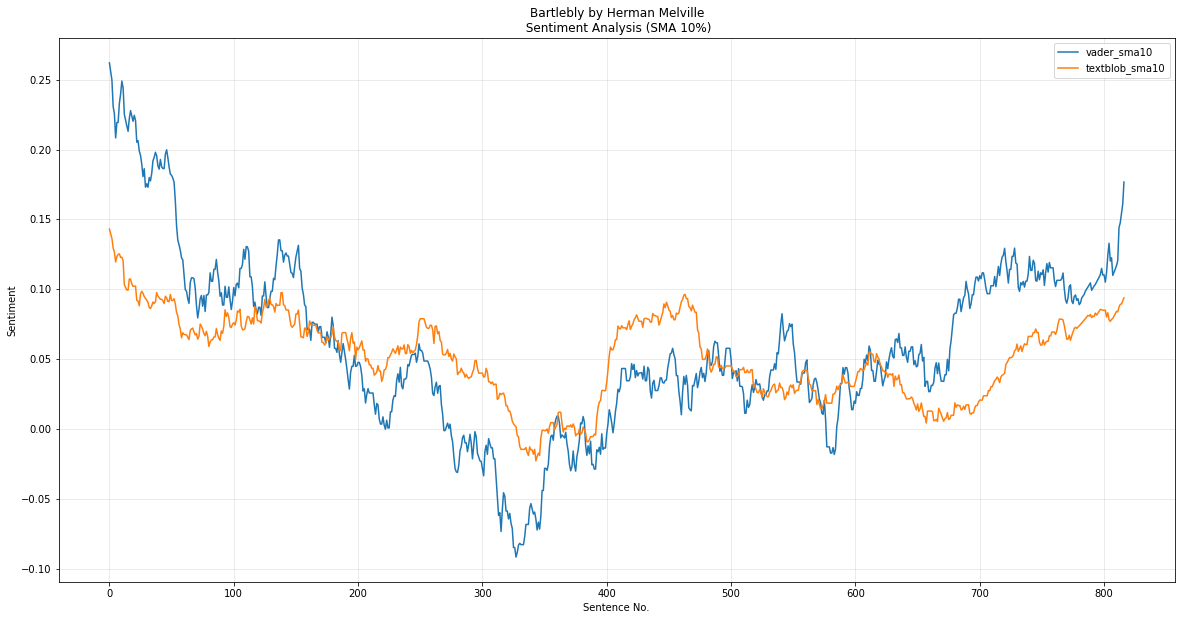

In [ ]:
#@title Enter the Sliding Window width as Percent of Novel length (default 10%, larger=smoother)

window_percent = 10 #@param {type:"slider", min:1, max:20, step:1}

win_per = int(window_percent/100 * sentiment_df.shape[0])

vader_col = f'vader_sma{window_percent}'
sentiment_df[vader_col] = sentiment_df['vader'].rolling(win_per, center=True, min_periods=1).mean()

textblob_col = f'textblob_sma{window_percent}'
sentiment_df[textblob_col] = sentiment_df['textblob'].rolling(win_per, center=True, min_periods=1).mean()
sentiment_df.plot(y=[vader_col, textblob_col])

plt.title(f'{Novel_Title}\n Sentiment Analysis (SMA {window_percent}%)')
plt.ylabel('Sentiment')
plt.xlabel('Sentence No.')
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.show();

In [ ]:
sentiment_df.head()

,text_raw,text_clean,text_raw_len,vader,textblob,vader_sma10,textblob_sma10
0,"﻿The Project Gutenberg eBook of Bartleby, The ...","the project gutenberg ebook of bartleby, the s...",237,-0.0790,0.187500,0.261905,0.143116
1,"You may copy it, give it away or re-use it und...","you may copy it, give it away or re-use it und...",150,0.0000,0.000000,0.255669,0.139708
2,"If you are not located in the United States, y...","if you are not located in the united states, y...",140,0.4215,0.000000,0.249723,0.136459
3,"Title: Bartleby, The Scrivener A Story...","title: bartleby, the scrivener a story of wall...",409,0.0000,0.166667,0.230732,0.129570
4,by Herman Melville I am a rat...,by herman melville i am a rather elderly man.,62,0.0000,0.000000,0.225604,0.126691


# **Crux Detection**

In [ ]:
#@title Which Lexicon?

Sentiment_Model = "VADER" #@param ["VADER", "TextBlob"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: PeakPropertyWarning: some peaks have a width of 0
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: PeakPropertyWarning: some peaks have a width of 0


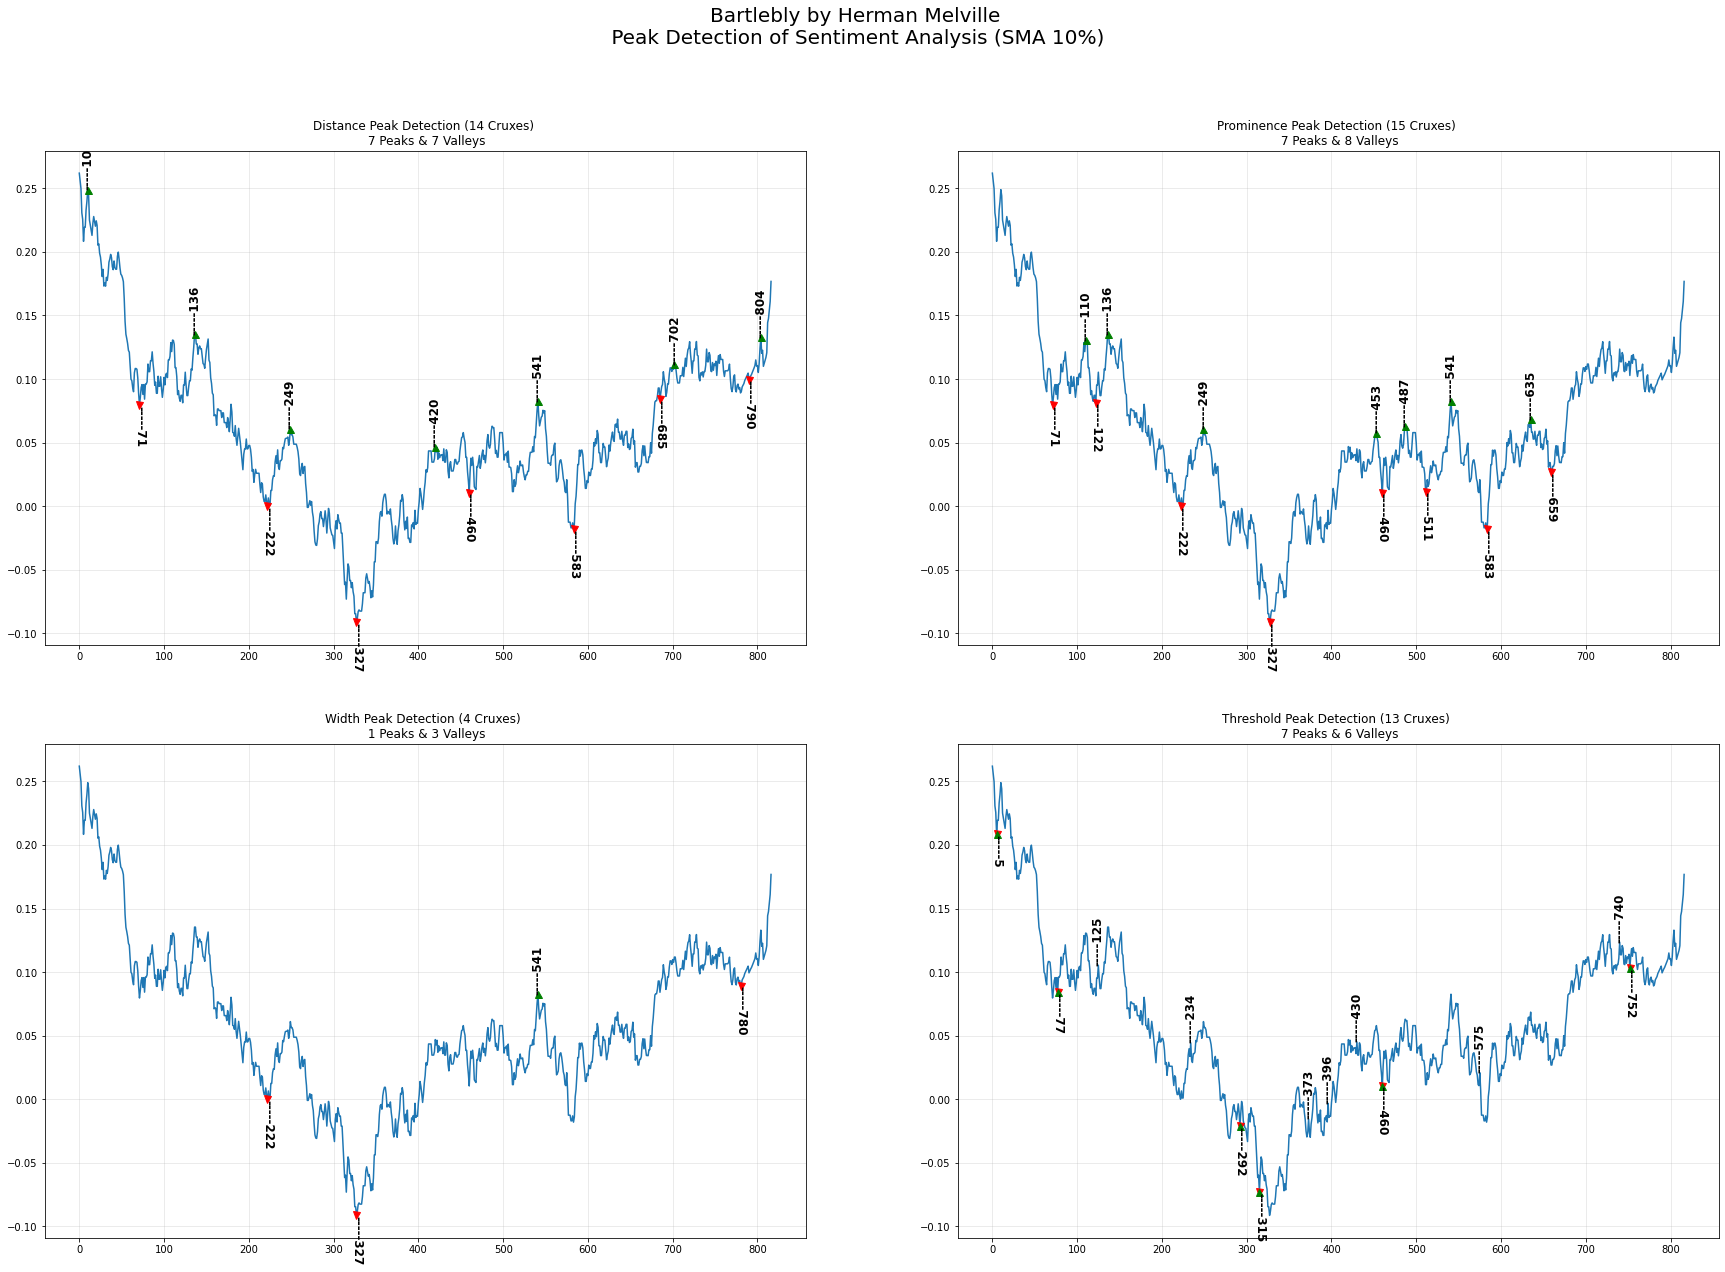

In [ ]:
#@title Tune the main Hyperparameter for each of the 4 Peak Detection Algorithms:

Distance_Min = 100 #@param {type:"slider", min:100, max:1000, step:10}
Prominence_Min = 0.041 #@param {type:"slider", min:0.001, max:0.05, step:0.001}
Width_Min = 25 #@param {type:"slider", min:25, max:500, step:5}
Threshold_Min = 0.009 #@param {type:"slider", min:0.001, max:0.01, step:0.001}

plt.rcParams['figure.figsize'] = [30, 20]

model_name = f'{Sentiment_Model.lower()}_sma{window_percent}'

x = sentiment_df[model_name]

# Peak Algo #1 (by Distance)
distance_min = Distance_Min # 750

# Peak Algo #2 (by Prominence)
prominence_min = Prominence_Min # 0.01

# Peak Algo #3 (by Width)
width_min = Width_Min # 175

# Peak Algo #4 (by Threshold)
threshold_min = Threshold_Min # 0.001


peaks, _ = find_peaks(x, distance=distance_min)
peaks2, _ = find_peaks(x, prominence=prominence_min)      # BEST!
peaks3, _ = find_peaks(x, width=width_min)
peaks4, _ = find_peaks(x, threshold=threshold_min)     # Required vertical distance to its direct neighbouring samples, pretty useless


x_inv = pd.Series([-x for x in sentiment_df[model_name].to_list()])

valleys, _ = find_peaks(x_inv, distance=distance_min)
valleys2, _ = find_peaks(x_inv, prominence=prominence_min)      # BEST!
valleys3, _ = find_peaks(x_inv, width=width_min)
valleys4, _ = find_peaks(x_inv, threshold=threshold_min)     # Required vertical distance to its direct neighbouring samples, pretty useless


_ = plt.subplot(2, 2, 1)
_ = plt.grid(True, alpha=0.3)
_ = plt.plot(x)
_ = plt.title(f'Distance Peak Detection ({len(peaks)+len(valleys)} Cruxes) \n {len(peaks)} Peaks & {len(valleys)} Valleys')
_ = plt.plot(peaks, x[peaks], "^g", markersize=7)
_ = plt.plot(valleys, x[valleys], "vr", markersize=7)
for x_val in peaks:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='bottom', rotation=90, size='large', color='black', weight='semibold')
for x_val in valleys:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='top', rotation=270, size='large', color='black', weight='semibold')

_ = plt.subplot(2, 2, 2)
_ = plt.grid(True, alpha=0.3)
_ = plt.plot(x)
_ = plt.title(f'Prominence Peak Detection ({len(peaks2)+len(valleys2)} Cruxes) \n {len(peaks2)} Peaks & {len(valleys2)} Valleys')
_ = plt.plot(peaks2, x[peaks2], "^g", markersize=7)
_ = plt.plot(valleys2, x[valleys2], "vr", markersize=7)
for x_val in peaks2:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='bottom', rotation=90, size='large', color='black', weight='semibold')
for x_val in valleys2:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='top', rotation=270, size='large', color='black', weight='semibold')


_ = plt.subplot(2, 2, 3)
_ = plt.grid(True, alpha=0.3)
_ = plt.plot(x)
_ = plt.title(f'Width Peak Detection ({len(peaks3)+len(valleys3)} Cruxes) \n {len(peaks3)} Peaks & {len(valleys3)} Valleys')
_ = plt.plot(valleys3, x[valleys3], "vr", markersize=7)
_ = plt.plot(peaks3, x[peaks3], "^g", markersize=7)
for x_val in peaks3:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='bottom', rotation=90, size='large', color='black', weight='semibold')
for x_val in valleys3:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='top', rotation=270, size='large', color='black', weight='semibold')


_ = plt.subplot(2, 2, 4)
_ = plt.grid(True, alpha=0.3)
_ = plt.plot(x)
_ = plt.title(f'Threshold Peak Detection ({len(peaks4)+len(valleys4)} Cruxes) \n {len(peaks4)} Peaks & {len(valleys4)} Valleys')
_ = plt.plot(valleys4, x[valleys4], "vr", markersize=7)
_ = plt.plot(valleys4, x[valleys4], "^g", markersize=7)
for x_val in peaks4:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='bottom', rotation=90, size='large', color='black', weight='semibold')
for x_val in valleys4:
  _ = plt.text(x_val, x[x_val], f'-----{x_val}', ha='center', va='top', rotation=270, size='large', color='black', weight='semibold')

_ = plt.suptitle(f'{Novel_Title}\n Peak Detection of Sentiment Analysis (SMA {window_percent}%)', fontsize=20)
_ = plt.grid(True, alpha=0.3)

_ = plt.show()

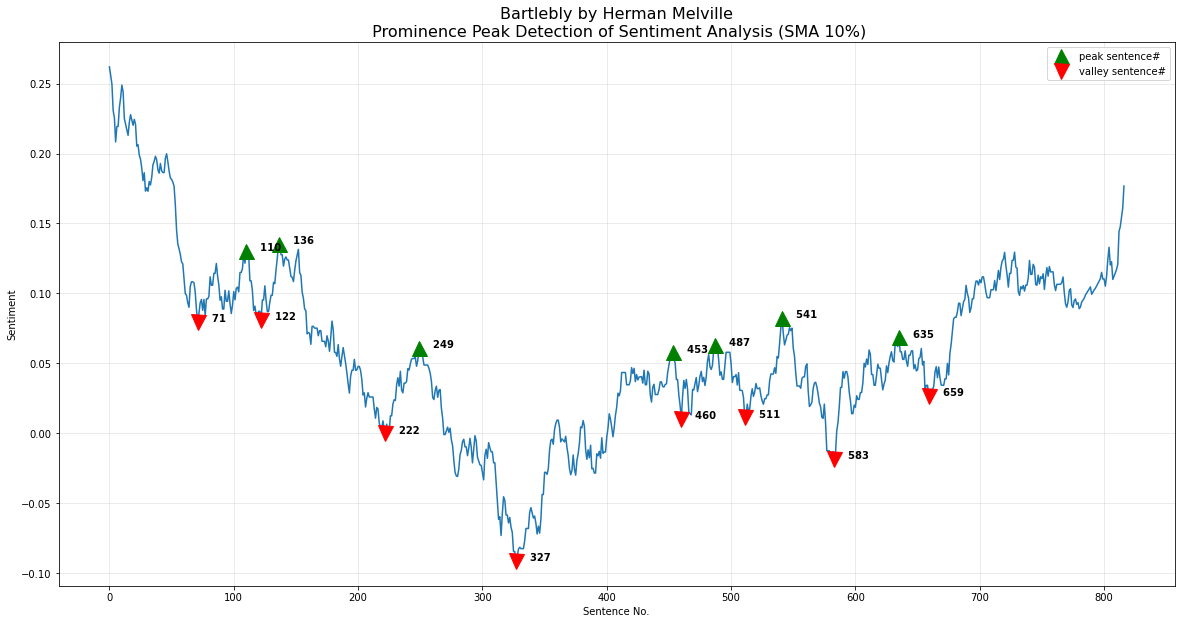



     >>>>> SAVED PLOT TO FILE: [cruxes_plot_Bartlebly_by_Herman_Melville.png] <<<<<


In [ ]:
#@title Select a Peak Detection Algorithms to View in Detail (usually Distance or Width is best):

plt.rcParams['figure.figsize'] = [20, 10]

Peak_Algorithm = "Prominence" #@param ["Distance", "Prominence", "Width", "Threshold"]

if Peak_Algorithm == 'Distance':
  peaks = peaks
  valleys = valleys
elif Peak_Algorithm == 'Prominence':
  peaks = peaks2
  valleys = valleys2  
elif Peak_Algorithm == 'Width':
  peaks = peaks3
  valleys = valleys3
else:
  # Assume Peak_Algorithm == 'Threshold'
  peaks = peaks4
  valleys = valleys4

# model_name = f'{Sentiment_Model.lower()}_sma10'

# x = novel_clean_df[model_name]

# peaks2, _ = find_peaks(x, prominence=peak_prominence)  

# x_inv = pd.Series([-x for x in novel_clean_df[model_name].to_list()])
# valleys2, _ = find_peaks(x_inv, prominence=peak_prominence)     

_ = plt.plot(x)
_ = plt.plot(peaks, x[peaks], "^g", markersize=15, label='peak sentence#')
_ = plt.plot(valleys, x[valleys], "vr", markersize=15, label='valley sentence#')
for x_val in peaks:
  _ = plt.text(x_val, x[x_val], f'    {x_val}', horizontalalignment='left', size='medium', color='black', weight='semibold')
for x_val in valleys:
  _ = plt.text(x_val, x[x_val], f'    {x_val}', horizontalalignment='left', size='medium', color='black', weight='semibold')
_ = plt.title(f'{Novel_Title}\n {Peak_Algorithm} Peak Detection of Sentiment Analysis (SMA {window_percent}%)', fontsize=16)
_ = plt.ylabel('Sentiment')
_ = plt.xlabel('Sentence No.')
_ = plt.legend(loc='best')
_ = plt.grid(True, alpha=0.3)

filename_plot = f"cruxes_plot_{Novel_Title.replace(' ', '_')}.png"
_ = plt.savefig(filename_plot, dpi=300)
_ = plt.show();

print(f'\n\n     >>>>> SAVED PLOT TO FILE: [{filename_plot}] <<<<<')

In [ ]:
# Download Crux Point Plot file 'crux_plot.png' to your laptop

files.download(filename_plot)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Get Context around Crux Points**

In [ ]:
#@title How many Sentences around Crux Point do you want to view for context?

Crux_Sentence_Context_Count = 19 #@param {type:"slider", min:1, max:20, step:1}


In [ ]:
# Print Context around each Sentiment Peak

output_ls = []

halfwin = int(Crux_Sentence_Context_Count/2)
crux_sents_ls = []
nl = '\n'

print('==================================================')
print('============     Peak Crux Points   ==============')
print('==================================================\n\n')

output_ls.append('==================================================')
output_ls.append('============     Peak Crux Points   ==============')
output_ls.append('==================================================\n\n')

# for i, apeak in enumerate(peaks2):
for i, apeak in enumerate(peaks):
  print(f'Processing Peak #{i}...')
  crux_sents_ls = []
  for sent_idx in range(apeak-halfwin,apeak+halfwin+1):
    sent_cur = sentiment_df.iloc[sent_idx].text_raw
    if sent_idx == apeak:
      sent_str = sent_cur.upper()
    else:
      sent_str = sent_cur
    crux_sents_ls.append(sent_str)
  
  # context_ls = sentiment_df.iloc[apeak-halfwin:apeak+halfwin].text_raw
  print(f"Peak #{i} at Sentence #{apeak}:\n\n{nl.join(crux_sents_ls)}\n\n\n")
  output_ls.append(f"Peak #{i} at Sentence #{apeak}:\n\n{nl.join(crux_sents_ls)}\n\n\n")

print('==================================================')
print('===========     Crux Valley Points    ============')
print('==================================================\n\n')

output_ls.append('==================================================')
output_ls.append('===========     Crux Valley Points    ============')
output_ls.append('==================================================\n\n')

# for i, avalley in enumerate(valleys2):
for i, avalley in enumerate(valleys):
  print(f'Processing Valley #{i}')
  crux_sents_ls = []
  for sent_idx in range(avalley-halfwin,avalley+halfwin+1):
    sent_cur = sentiment_df.iloc[sent_idx].text_raw
    if sent_idx == avalley:
      sent_str = sent_cur.upper()
    else:
      sent_str = sent_cur
    crux_sents_ls.append(sent_str)

  # context_ls = novel_df.iloc[avalley-halfwin:avalley+halfwin].text_raw
  print(f"Valley #{i} at Sentence #{avalley}:\n\n{nl.join(crux_sents_ls)}\n\n\n")
  output_ls.append(f"Valley #{i} at Sentence #{avalley}:\n\n{nl.join(crux_sents_ls)}\n\n\n")

filename_cruxes = f"cruxes_context_{Novel_Title.replace(' ', '_')}.txt" 

output_str = ' '.join(output_ls)

with open(filename_cruxes, 'w') as f:
    f.write(output_str)

============     Peak Crux Points   ==============


Processing Peak #0...
Peak #0 at Sentence #110:

His
father was a carman, ambitious of seeing his son on the bench instead
of a cart, before he died.
So he sent him to my office as student at
law, errand boy, and cleaner and sweeper, at the rate of one dollar a
week.
He had a little desk to himself, but he did not use it much.
Upon
inspection, the drawer exhibited a great array of the shells of various
sorts of nuts.
Indeed, to this quick-witted youth the whole noble
science of the law was contained in a nut-shell.
Not the least among
the employments of Ginger Nut, as well as one which he discharged with
the most alacrity, was his duty as cake and apple purveyor for Turkey
and Nippers.
Copying law papers being proverbially dry, husky sort of
business, my two scriveners were fain to moisten their mouths very
often with Spitzenbergs to be had at the numerous stalls nigh the
Custom House and Post Office.
Also, they sent Ginger Nut very


33760

In [ ]:
# Download Crux Point Report file 'cruxes.txt' to your laptop

files.download(filename_cruxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!cat $filename_cruxes

================================================== ============     Peak Crux Points   ============== ==================================================

 Peak #0 at Sentence #110:

His
father was a carman, ambitious of seeing his son on the bench instead
of a cart, before he died.
So he sent him to my office as student at
law, errand boy, and cleaner and sweeper, at the rate of one dollar a
week.
He had a little desk to himself, but he did not use it much.
Upon
inspection, the drawer exhibited a great array of the shells of various
sorts of nuts.
Indeed, to this quick-witted youth the whole noble
science of the law was contained in a nut-shell.
Not the least among
the employments of Ginger Nut, as well as one which he discharged with
the most alacrity, was his duty as cake and apple purveyor for Turkey
and Nippers.
Copying law papers being proverbially dry, husky sort of
business, my two scriveners were fain to moisten their mouths very
often with Spitzenbergs to be had at the numerou

# **END OF NOTEBOOK**